In [1]:
import csv
import numpy as np
import pandas as pd

import tensorflow as tf
from keras import backend as K
num_cores = 6

num_CPU = 1
num_GPU = 0

config = tf.ConfigProto(intra_op_parallelism_threads=num_cores,\
        inter_op_parallelism_threads=num_cores, allow_soft_placement=True,\
        device_count = {'CPU' : num_CPU, 'GPU' : num_GPU})
session = tf.Session(config=config)
K.set_session(session)

from keras.models import load_model
from sklearn.externals import joblib

# Load model, best weights and scaler
model = load_model('model.h5')
model.load_weights("weights.hdf5")

Using TensorFlow backend.


In [2]:
import pandas as pd
import numpy as np

df = pd.read_csv("poloniex_usdt_btc_20170101_DOHLCV_300.csv", sep=";", index_col=None)
df.head()

# Turn dataframe into a numpy floating point array
df_values = df.values
timestamps = df_values[:, 0]
dataset = df_values[:, 1:].astype("float")


samples_num = dataset.shape[0]

valid_split = 0.05
test_split = 0.05

dataset_train = dataset[0:int(samples_num * (1-valid_split-test_split))]
dataset_valid = dataset[int(samples_num * (1-valid_split-test_split)):int(samples_num * (1-test_split))]
dataset_test = dataset[int(samples_num * (1-test_split)):samples_num]

print(dataset_test.shape)

# Makes a training examples from year data with a timesteps window size

def makeXy(data, timesteps):
    X = []
    y = []
    
    for i in range(timesteps, data.shape[0]):
        X.append(list(data[i-timesteps:i]))
        y.append(data[i])
        
    X, y = np.array(X), np.array(y)
    return X, y

timestep = 250 # Make decision from last 'timestep' candles

# Create training examples

train_X, train_y = makeXy(dataset_train, timestep)
valid_X, valid_y = makeXy(dataset_valid, timestep)
test_X, test_y = makeXy(dataset_test, timestep)
    
train_y = train_y[:, :5]
valid_y = valid_y[:, :5]
test_y = test_y[:, :5]
    
train_y = np.expand_dims(train_y, axis=1)
valid_y = np.expand_dims(valid_y, axis=1)
test_y = np.expand_dims(test_y, axis=1)

print(test_X.shape)
print(test_y.shape)

(9382, 5)
(9132, 250, 5)
(9132, 1, 5)


In [3]:
from sklearn.preprocessing import MinMaxScaler
import sys

pred_data = test_X
# pred_data = test_X

prediction_range = 50
prediction_lookback = timestep

predictions = np.zeros(pred_data[0].shape)

for i in range(0, (pred_data.shape[0]-prediction_range)//prediction_range * prediction_range, prediction_range):
    sys.stdout.write("\r" + str(i) + "/" + str(pred_data.shape[0]) )
    sys.stdout.flush()
    
    r = pred_data[i]
    scaler = MinMaxScaler().fit(r)
    r = scaler.transform(r)
    
    for candles in range(prediction_range):
        d = r[-prediction_lookback:] 
#         print(d.shape)
        d = np.expand_dims(d, axis=0) # NN waits for array, we use just 1 candle as input
        next = model.predict(d, batch_size=1)
        r = np.append(r, next, axis=0) # Add prediction to known candles
        next = next.reshape(-1,)[0]
    
    r = scaler.inverse_transform(r[-prediction_range:])
    predictions = np.append(predictions, r, axis=0)
        

9000/9132

In [4]:
print(predictions.shape)

test_close = pred_data[prediction_lookback:,0, 3]
pred_close = predictions[prediction_lookback:, 3]

print(test_close.shape)
print(pred_close.shape)

(9300, 5)
(8882,)
(9050,)


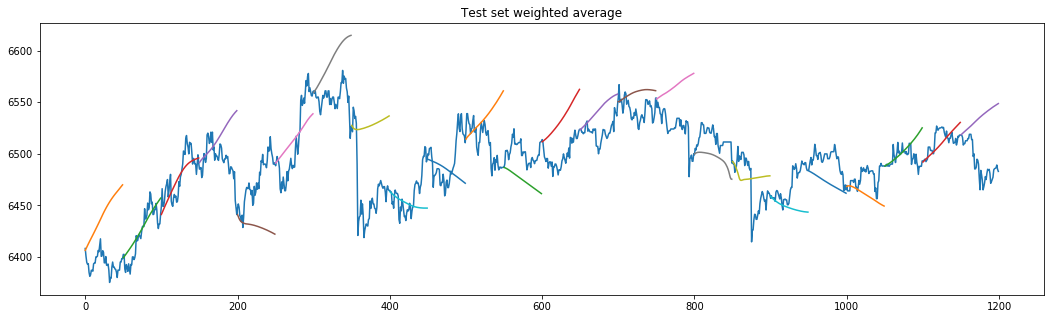

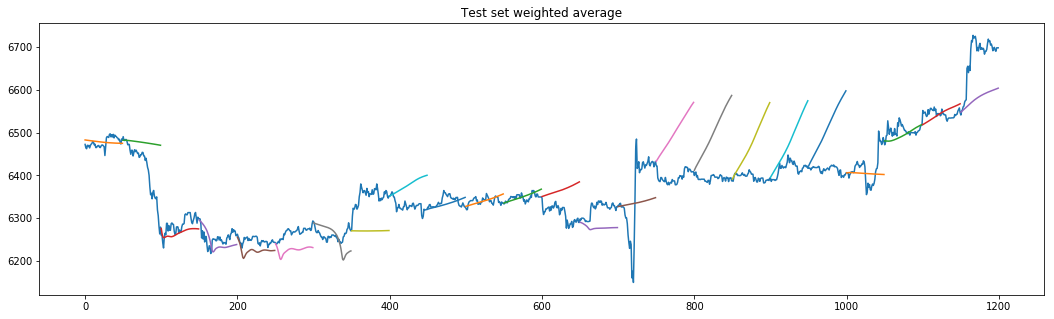

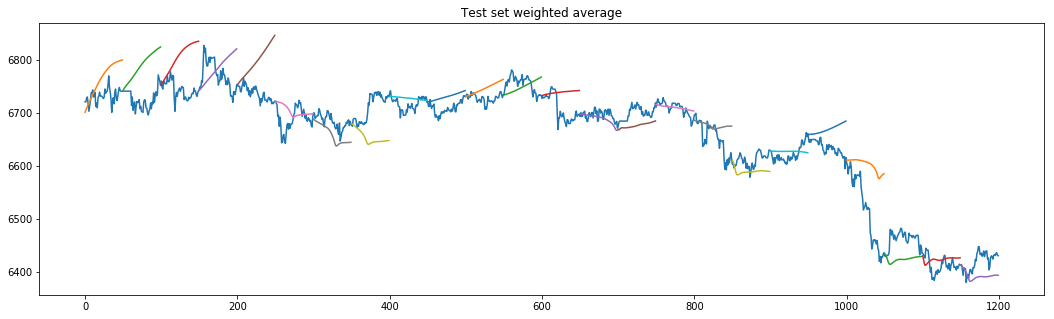

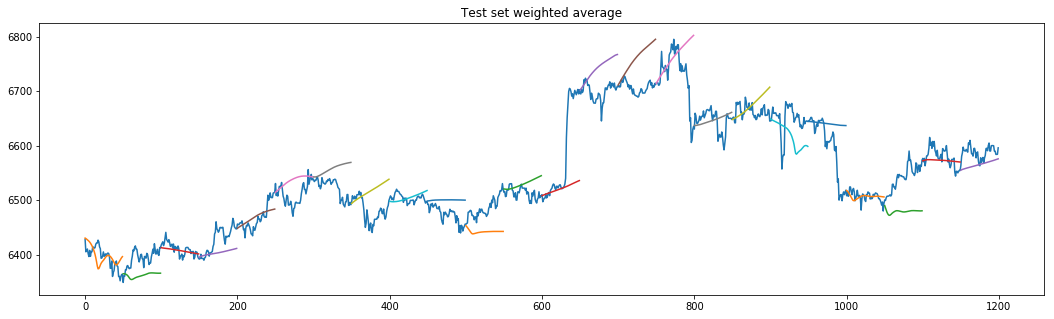

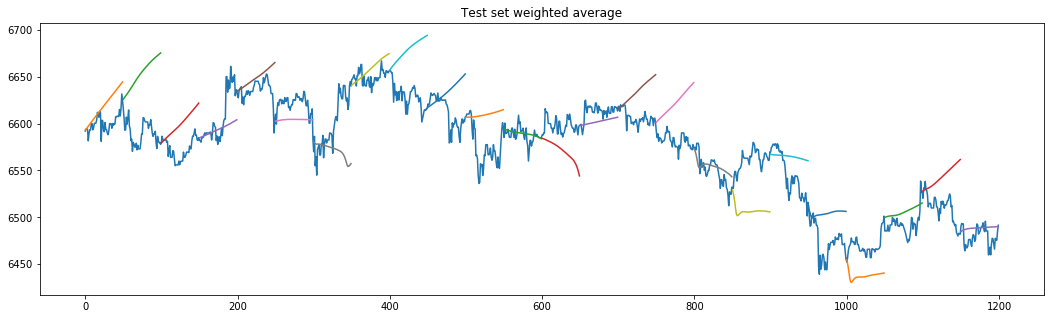

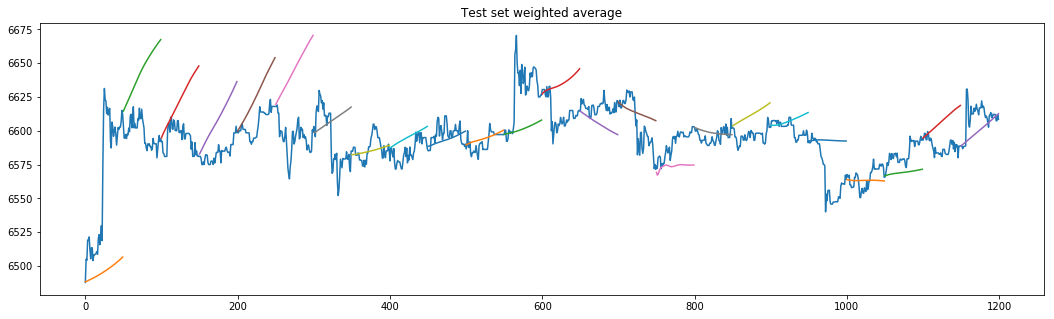

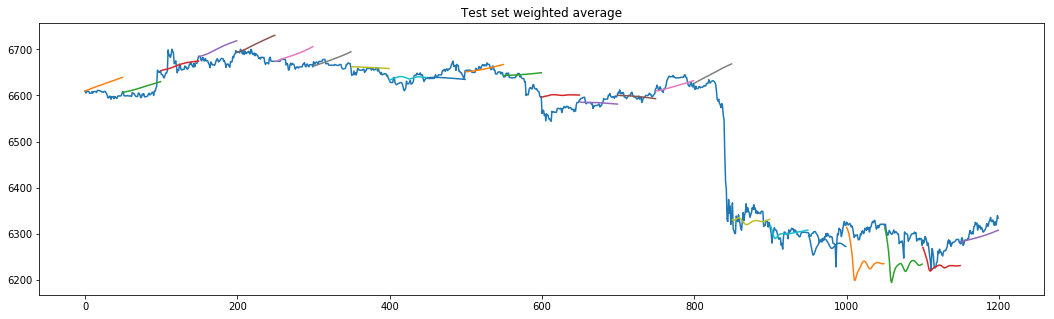

In [6]:
import matplotlib.pyplot as plt

plot_length = 1200
number_of_plots = predictions.shape[0] // plot_length

for i in range(number_of_plots):
    
    plt.figure(figsize=(18, 5))
    plt.title('Test set weighted average')
    start = i*plot_length
    end = (i+1)*plot_length
    plt.plot(test_close[start:end])
    for k in range(start, end, prediction_range):
        plt.plot([None for j in range(k-start)] + [x for x in pred_close[k:k+prediction_range]])
    plt.show()